<a href="https://colab.research.google.com/github/athankefalas/TrafficCongestionSNA/blob/master/ICM%26TwoStep%26Heuristics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt

In [19]:
#download graph from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
file1 = '/content/drive/My Drive/SNA/Data/ia-email-univ/ia-email-univ.mtx' #google drive path
file2 = '/content/drive/My Drive/SNA/Data/inf-euroroad/inf-euroroad.edges'
file3 = '/content/drive/My Drive/SNA/Data/inf-power/inf-power.mtx'
file4 = '/content/drive/My Drive/SNA/Data/soc-advogato/soc-advogato.edges'
file5 = '/content/drive/My Drive/SNA/Data/socfb-Rochester38/socfb-Rochester38.mtx'
file=file1
g = nx.read_adjlist(file)

In [21]:
#number of nodes
nodes = len(g.nodes())
print("The number of nodes is",nodes)
#number of edges
edges = len(g.edges())
print("The number of edges is", edges)
#max_degree
max_degree=max(dict(g.degree()).items(), key = lambda x : x[1])[1]
print("The maximum degree is:", max_degree)



The number of nodes is 1139
The number of edges is 5457
The maximum degree is: 71


In [0]:
if not g.is_directed():
    g = g.to_directed()

In [23]:

#top five nodes with the highest degree centrality
degree_centrality=nx.degree_centrality(g)
sorted_degree_centrality=sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_degree_centrality_nodes=[i[0] for i in sorted_degree_centrality]
print("The five nodes with the highest degree centrality scores are: ", top_degree_centrality_nodes)

#top five nodes with the highest closeness centrality
closeness_centrality=nx.closeness_centrality(g)
sorted_closeness_centrality=sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_closeness_centrality_nodes=[i[0] for i in sorted_closeness_centrality]
print("The five nodes with the highest closeness centrality scores are: ", top_closeness_centrality_nodes)

#top five nodes with the highest betweenness centrality
betweenness_centrality=nx.betweenness_centrality(g)
sorted_betweenness_centrality=sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_betweenness_centrality_nodes=[i[0] for i in sorted_betweenness_centrality]
print("The five nodes with the highest betweenness centrality scores are: ", top_betweenness_centrality_nodes)

The five nodes with the highest degree centrality scores are:  ['105', '333', '16', '23', '42']
The five nodes with the highest closeness centrality scores are:  ['333', '23', '105', '42', '41']
The five nodes with the highest betweenness centrality scores are:  ['333', '105', '23', '578', '76']


In [24]:
#nodes with the highest pagerank
pageranked = nx.pagerank(g, alpha=0.85)
sorted_pageranked = sorted(pageranked.items(), key=lambda x: x[1], reverse=True)[:5]
top_pageranked_nodes = [i[0] for i in sorted_pageranked]
print("The five nodes with the highest PageRank scores are: ", top_pageranked_nodes)
#nodes with the highest hub scores(HITS Algorithm)
hubscore = nx.hits(g)
sorted_hubscore = sorted(hubscore[0].items(), key=lambda x: x[1], reverse=True)[:5]
top_hubscore_nodes = [i[0] for i in sorted_hubscore]
print("The five nodes with the highest hub scores are: ", top_hubscore_nodes)
#nodes with the highest authority scores(HITS Algorithm)
authorityscore = nx.hits(g)
sorted_authorityscore = sorted(authorityscore[1].items(), key=lambda x: x[1], reverse=True)[:5]
top_authorityscore_nodes = [i[0] for i in sorted_authorityscore]
print("The five nodes with the highest authority scores are: ", top_authorityscore_nodes)

The five nodes with the highest PageRank scores are:  ['105', '23', '333', '41', '42']
The five nodes with the highest hub scores are:  ['105', '16', '196', '204', '42']
The five nodes with the highest authority scores are:  ['105', '16', '196', '204', '42']


In [0]:
#FUNCTION to set activation RANDOM probabilities 
def set_activation_probabilities(G):
  attr={}
  for edge in G.edges():
    attr.update( {edge : np.random.uniform(0.0, 0.2)})
                                                 
  nx.set_edge_attributes(G, attr, 'prob')
  
  return G

In [0]:
g=set_activation_probabilities(g)

In [0]:
#FUNCTION for each iteration of diffusion process 
def diffusion_process(Graph,Seed,Visited):
  iter_activations = set()   #this iteration's activations
  iter_visits = set()        #this iteration's visits
  for s in Seed:
    for n in Graph.successors(s):  #successor of n is a node m such that there exists a directed edge from n to m
      if (s, n) in Visited or (s, n) in iter_visits or  n in Seed:   #check if successor was visited before, or seed tried before
        continue
      
      diffusion_prob = g[s][n]['prob']
      activation_prob = np.random.uniform(0.0, 1.0)
      activation = activation_prob >= (1.0-diffusion_prob)
      
      if activation:               
        iter_activations.add(n)

      iter_visits.add((s, n))

  iter_activations = list(iter_activations)
  Seed.extend(iter_activations)
  return Seed, iter_activations, iter_visits

In [0]:
#FUNCTION for ICM and two step ICM 
def ICM(g,seeds,num_iter,multi_step=False,step_iter=0):
  visited_edges = set() 
  activated_nodes = []
  num_nodes=[]
  len_seeds=len(seeds)
  
  if multi_step==True:  #split the seed nodes to 2 groups for two step
    
    multi_seeds=seeds[len_seeds//2:]
    seeds=seeds[0:len_seeds//2]
    
    print('Diffusion model : Two step ICM')
    print('Starting diffusion for', num_iter,'iterations, with seed nodes:',seeds,'and additional seed nodes:',multi_seeds,'added at',step_iter,'iterations')
  else:
    print('Diffusion model : ICM')
    print('Starting diffusion for', num_iter,'iterations, with starting seed nodes:',seeds)
    
  for s in seeds:
    activated_nodes.append(s)
  num_nodes.append(len_seeds)
  
  while True:
    len_seeds=len(seeds)
    
    if multi_step==True and num_iter==step_iter: #activate multi_seeds
      for s in multi_seeds:
        seeds.append(s)
      
    seeds, iter_activations, iter_visits = diffusion_process(g, seeds, visited_edges)
    
    num_nodes.append(len(iter_activations))
    
    for i in iter_activations:
      activated_nodes.append(i)
    visited_edges = visited_edges.union(iter_visits)
    
    if len(seeds) == len_seeds:
      break
    len_seeds=len(seeds)
    num_iter-= 1
    if not num_iter or len(seeds) >= len(g):
      break

  return activated_nodes,num_nodes

In [38]:
#simple ICM
#create seed nodes
seeds=top_betweenness_centrality_nodes[:5] 
#number of iterations
num_iter=20
act_n1,act_per_iter1=ICM(g,seeds,num_iter)
print("Nodes activated:",len(act_n1))
#print("Activations per itteration",act_per_iter1)
print("Iterations occured:",len(act_per_iter1)-1)
# plt.title('Activations per itteration')
# plt.plot(act_per_iter1)
# plt.ylabel('Number of diffusions')
# plt.xlabel('Number of itterations')
# plt.show()

Diffusion model : ICM
Starting diffusion for 20 iterations, with starting seed nodes: ['333', '105', '23', '578', '76']
Nodes activated: 361
Iterations occured: 16


In [39]:
#Two step ICM
#create seed nodes
seeds=top_betweenness_centrality_nodes[:5] 
#number of iterations
num_iter=20
act_n2,act_per_iter2=ICM(g,seeds,num_iter,multi_step=True,step_iter=6)
print("Nodes activated:",len(act_n2))
#print("Activations per itteration",act_per_iter2)
print("Iterations occured:",len(act_per_iter2)-1)

# plt.title('Activations per itteration')
# plt.plot(act_per_iter2)
# plt.ylabel('Number of diffusions')
# plt.xlabel('Number of itterations')
# plt.show()

Diffusion model : Two step ICM
Starting diffusion for 20 iterations, with seed nodes: ['333', '105'] and additional seed nodes: ['23', '578', '76'] added at 6 iterations
Nodes activated: 417
Iterations occured: 19


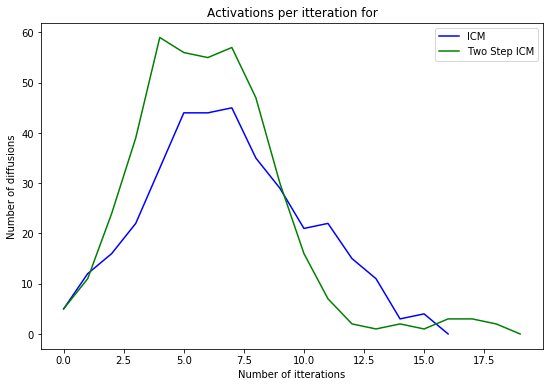

In [45]:
plt.figure(figsize=(9,6))

line_up,=plt.plot(act_per_iter1,'b', label='ICM')
line_down,=plt.plot(act_per_iter2,'g', label='Two Step ICM')
plt.legend(handles=[line_up, line_down])
plt.title('Activations per itteration for')
plt.ylabel('Number of diffusions')
plt.xlabel('Number of itterations')
plt.show()